In [1]:
%cd drive/My\ Drive/Colab\ Notebooks/DLG/semantic-mediawiki-page-creation/semantic-mediawiki-page-creation/sql-notebooks

/content/drive/My Drive/Colab Notebooks/DLG/semantic-mediawiki-page-creation/semantic-mediawiki-page-creation/sql-notebooks


In [16]:
from google.colab import auth
auth.authenticate_user()

In [17]:
from getpass import getpass
pjt_code = getpass('ProjectCode: ')

ProjectCode: ··········


# Question Talks Data

In [31]:
%%bigquery --project {pjt_code} df_question_talk_data
DECLARE start_date DATE DEFAULT "2019-01-01";
DECLARE end_date DATE DEFAULT "2020-12-31";
DECLARE channel_text STRING DEFAULT "03%質問%";
DECLARE ignore_text STRING DEFAULT "<%>さんがチャンネルに参加しました";


WITH 
-- [START] Create reply table
-- 1. get all talk data with filling the null thread_ts as ts
all_talks_with_filled_thread_ts AS (
  SELECT
    channel_id, ts AS thread_ts, ts, talk_user, talk_id
  FROM
    mgm.talk
  WHERE
    target_date >= start_date AND target_date <= end_date AND
    thread_ts IS NULL AND -- fill null thread_ts as ts
    talk_user IS NOT NULL -- exclude bot talks
  UNION ALL
  SELECT
    channel_id, thread_ts, ts, talk_user, talk_id
  FROM
    mgm.talk
  WHERE
    target_date >= start_date AND target_date <= end_date AND
    thread_ts IS NOT NULL AND -- if thread_ts is not null no replace
    talk_user IS NOT NULL -- exclude bot talks
),
all_talks_without_duplicated_talk_ids AS (
  SELECT
    a.channel_id, a.thread_ts, a.ts, a.talk_user, a.talk_id, r.target_date
  FROM
  (
    SELECT
      channel_id, thread_ts, ts, talk_user, MIN(talk_id) AS talk_id
    FROM
      all_talks_with_filled_thread_ts
    GROUP BY
      channel_id, thread_ts, ts, talk_user
  ) a
  LEFT JOIN
  (
    SELECT
      DISTINCT talk_id, target_date
    FROM
      mgm.talk
    WHERE
      target_date >= start_date AND target_date <= end_date
  ) r
  ON
    a.talk_id = r.talk_id
),
-- 2. get first talk ts in all threads
-- mainly first talk ts = thread_ts but it's not same in in some cases
first_talk_in_threads AS (
  SELECT
    channel_id, thread_ts, MIN(ts) AS ts -- get MIN(ts) because some first talk ts > thread_ts
  FROM
    all_talks_without_duplicated_talk_ids
  GROUP BY
    channel_id, thread_ts
  ORDER BY thread_ts
),
-- 3. join the talk_user, talk_id for first talks
thread_first_user_master AS (
  SELECT
    f.channel_id, f.thread_ts, f.ts, a.talk_user, a.talk_id, a.target_date
  FROM
    first_talk_in_threads f
      LEFT JOIN
        all_talks_without_duplicated_talk_ids a
      ON
        f.channel_id = a.channel_id AND f.thread_ts = a.thread_ts AND f.ts = a.ts
),
-- 4. get the reply talks (non first talks) on each threads
reply_talk_data AS (
  SELECT
    channel_id, thread_ts, ts, talk_user, talk_id, target_date
  FROM
    all_talks_without_duplicated_talk_ids AS raw
  WHERE
    talk_user IS NOT NULL AND
    NOT EXISTS(
      SELECT talk_id
      FROM thread_first_user_master AS mstr
      WHERE raw.talk_id = mstr.talk_id
    )
),
-- 5. join as reply table
reply_table AS (
  SELECT
    rp.channel_id,
    ROW_NUMBER() OVER(PARTITION BY rp.channel_id, rp.thread_ts ORDER BY rp.thread_ts, rp.ts, rp.channel_id) AS reply_num,
    rp.ts AS reply_ts, rp.talk_id AS reply_id, rp.talk_user AS reply_user,
    tm.thread_ts, tm.talk_id AS talk_id, tm.talk_user AS talk_user, rp.target_date
  FROM 
    reply_talk_data rp
      LEFT JOIN
        thread_first_user_master tm
      ON
        rp.channel_id = tm.channel_id AND rp.thread_ts = tm.thread_ts
  ORDER BY
    tm.thread_ts, rp.ts, rp.channel_id
),
-- [END] Create reply table
-- [START] Concat all talk data as reply table format
all_talk_data_in_reply_format AS (
  SELECT
    channel_id, 0 AS reply_num, ts AS reply_ts, talk_id AS reply_id,
    talk_user AS reply_user, thread_ts, talk_id AS talk_id, talk_user AS talk_user, target_date
  FROM
    thread_first_user_master
  UNION ALL
  SELECT
    *
  FROM
    reply_table
  ORDER BY thread_ts, reply_ts
),
-- [END] Concat all talk data as reply table format
-- [START] Create question channel master
question_channel_master AS (
  SELECT
    DISTINCT id AS channel_id, name AS channel_name, target_date
  FROM
    mgm.channel
  WHERE
    target_date >= start_date AND target_date <= end_date AND
    name LIKE channel_text
),
-- [END] Create question channel master
-- [START] Create user name master
-- Get user name data for each target dates
user_names_with_date AS (
  SELECT
    user_id, real_name_normalized AS user_name, target_date
  FROM
    mgm.user
  WHERE
      target_date >= start_date AND target_date <= end_date AND
      display_name_normalized IS NULL -- use real name when display name is null
  UNION DISTINCT
  SELECT
    user_id, display_name_normalized AS user_name, target_date
  FROM
    mgm.user
  WHERE
      target_date >= start_date AND target_date <= end_date AND
      display_name_normalized IS NOT NULL -- use display name when not null
  ORDER BY target_date, user_id
),
-- Get the flag that each user are in the latest target date
user_in_current_table AS (
  SELECT
    user_id,
    MAX(target_date) = (SELECT MAX(target_date) FROM user_names_with_date) AS is_in_current
  FROM
    user_names_with_date
  GROUP BY
    user_id
),
-- Join the name & is in current flag
user_name_master AS (
  SELECT
    DISTINCT n.user_id, n.user_name, n.target_date, c.is_in_current
  FROM
    user_names_with_date n
  LEFT JOIN
    user_in_current_table c
  ON
    n.user_id = c.user_id
),
-- [END] Create user name master
-- [START] Get talk table with target date filtering
talk_table AS(
  SELECT
   DISTINCT talk_id, text
  FROM
    mgm.talk
  WHERE
    target_date >= start_date AND target_date <= end_date AND
    text NOT LIKE ignore_text
)
-- [END] Get talk table with target date filtering

SELECT
  q.channel_id, q.channel_name,
  a.reply_num,a.reply_user AS user_id, u.user_name AS user_name,
  u.is_in_current AS reply_user_is_in_current,
  a.reply_id AS talk_id, t.text AS talk_text, a.reply_ts AS talk_ts, 
  a.thread_ts, a.target_date, 

FROM
  all_talk_data_in_reply_format a
  INNER JOIN
    question_channel_master q
  ON
    a.channel_id = q.channel_id AND a.target_date = q.target_date
  LEFT JOIN
    user_name_master u
  ON a.reply_user = user_id AND a.target_date = u.target_date
  INNER JOIN
    talk_table t
  ON a.reply_id = t.talk_id
  ORDER BY channel_name, thread_ts, reply_ts
;

In [32]:
df_question_talk_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4011 entries, 0 to 4010
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   channel_id                4011 non-null   object             
 1   channel_name              4011 non-null   object             
 2   reply_num                 4011 non-null   int64              
 3   user_id                   4011 non-null   object             
 4   user_name                 4011 non-null   object             
 5   reply_user_is_in_current  4011 non-null   bool               
 6   talk_id                   4011 non-null   object             
 7   talk_text                 4011 non-null   object             
 8   talk_ts                   4011 non-null   datetime64[ns, UTC]
 9   thread_ts                 4011 non-null   datetime64[ns, UTC]
 10  target_date               4011 non-null   object             
dtypes: bool(1), datet

In [33]:
import pandas as pd
df_question_talk_data.to_csv('question_talk_data.csv', index=False)

In [34]:
!pip install japanize-matplotlib

In [35]:
import japanize_matplotlib

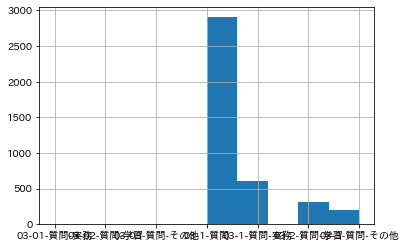

In [36]:
df_question_talk_data['channel_name'].hist()

In [37]:
df_question_talk_data['channel_name'].value_counts()

03-1-質問         2904
03-1-質問-実務       601
03-2-質問-学習       306
03-3-質問-その他      194
03-03-質問-その他       4
03-02-質問-学習        1
03-01-質問-実務        1
Name: channel_name, dtype: int64

# Introduction Talk Data
* Use the same query as question talks
* change the channel to '自己紹介'

In [38]:
%%bigquery --project {pjt_code} df_intro_talk_data
DECLARE start_date DATE DEFAULT "2019-01-01";
DECLARE end_date DATE DEFAULT "2020-12-31";
DECLARE channel_text STRING DEFAULT "01%自己紹介%";
DECLARE ignore_text STRING DEFAULT "<%>さんがチャンネルに参加しました";


WITH 
-- [START] Create reply table
-- 1. get all talk data with filling the null thread_ts as ts
all_talks_with_filled_thread_ts AS (
  SELECT
    channel_id, ts AS thread_ts, ts, talk_user, talk_id
  FROM
    mgm.talk
  WHERE
    target_date >= start_date AND target_date <= end_date AND
    thread_ts IS NULL AND -- fill null thread_ts as ts
    talk_user IS NOT NULL -- exclude bot talks
  UNION ALL
  SELECT
    channel_id, thread_ts, ts, talk_user, talk_id
  FROM
    mgm.talk
  WHERE
    target_date >= start_date AND target_date <= end_date AND
    thread_ts IS NOT NULL AND -- if thread_ts is not null no replace
    talk_user IS NOT NULL -- exclude bot talks
),
all_talks_without_duplicated_talk_ids AS (
  SELECT
    a.channel_id, a.thread_ts, a.ts, a.talk_user, a.talk_id, r.target_date
  FROM
  (
    SELECT
      channel_id, thread_ts, ts, talk_user, MIN(talk_id) AS talk_id
    FROM
      all_talks_with_filled_thread_ts
    GROUP BY
      channel_id, thread_ts, ts, talk_user
  ) a
  LEFT JOIN
  (
    SELECT
      DISTINCT talk_id, target_date
    FROM
      mgm.talk
    WHERE
      target_date >= start_date AND target_date <= end_date
  ) r
  ON
    a.talk_id = r.talk_id
),
-- 2. get first talk ts in all threads
-- mainly first talk ts = thread_ts but it's not same in in some cases
first_talk_in_threads AS (
  SELECT
    channel_id, thread_ts, MIN(ts) AS ts -- get MIN(ts) because some first talk ts > thread_ts
  FROM
    all_talks_without_duplicated_talk_ids
  GROUP BY
    channel_id, thread_ts
  ORDER BY thread_ts
),
-- 3. join the talk_user, talk_id for first talks
thread_first_user_master AS (
  SELECT
    f.channel_id, f.thread_ts, f.ts, a.talk_user, a.talk_id, a.target_date
  FROM
    first_talk_in_threads f
      LEFT JOIN
        all_talks_without_duplicated_talk_ids a
      ON
        f.channel_id = a.channel_id AND f.thread_ts = a.thread_ts AND f.ts = a.ts
),
-- 4. get the reply talks (non first talks) on each threads
reply_talk_data AS (
  SELECT
    channel_id, thread_ts, ts, talk_user, talk_id, target_date
  FROM
    all_talks_without_duplicated_talk_ids AS raw
  WHERE
    talk_user IS NOT NULL AND
    NOT EXISTS(
      SELECT talk_id
      FROM thread_first_user_master AS mstr
      WHERE raw.talk_id = mstr.talk_id
    )
),
-- 5. join as reply table
reply_table AS (
  SELECT
    rp.channel_id,
    ROW_NUMBER() OVER(PARTITION BY rp.channel_id, rp.thread_ts ORDER BY rp.thread_ts, rp.ts, rp.channel_id) AS reply_num,
    rp.ts AS reply_ts, rp.talk_id AS reply_id, rp.talk_user AS reply_user,
    tm.thread_ts, tm.talk_id AS talk_id, tm.talk_user AS talk_user, rp.target_date
  FROM 
    reply_talk_data rp
      LEFT JOIN
        thread_first_user_master tm
      ON
        rp.channel_id = tm.channel_id AND rp.thread_ts = tm.thread_ts
  ORDER BY
    tm.thread_ts, rp.ts, rp.channel_id
),
-- [END] Create reply table
-- [START] Concat all talk data as reply table format
all_talk_data_in_reply_format AS (
  SELECT
    channel_id, 0 AS reply_num, ts AS reply_ts, talk_id AS reply_id,
    talk_user AS reply_user, thread_ts, talk_id AS talk_id, talk_user AS talk_user, target_date
  FROM
    thread_first_user_master
  UNION ALL
  SELECT
    *
  FROM
    reply_table
  ORDER BY thread_ts, reply_ts
),
-- [END] Concat all talk data as reply table format
-- [START] Create question channel master
question_channel_master AS (
  SELECT
    DISTINCT id AS channel_id, name AS channel_name, target_date
  FROM
    mgm.channel
  WHERE
    target_date >= start_date AND target_date <= end_date AND
    name LIKE channel_text
),
-- [END] Create question channel master
-- [START] Create user name master
-- Get user name data for each target dates
user_names_with_date AS (
  SELECT
    user_id, real_name_normalized AS user_name, target_date
  FROM
    mgm.user
  WHERE
      target_date >= start_date AND target_date <= end_date AND
      display_name_normalized IS NULL -- use real name when display name is null
  UNION DISTINCT
  SELECT
    user_id, display_name_normalized AS user_name, target_date
  FROM
    mgm.user
  WHERE
      target_date >= start_date AND target_date <= end_date AND
      display_name_normalized IS NOT NULL -- use display name when not null
  ORDER BY target_date, user_id
),
-- Get the flag that each user are in the latest target date
user_in_current_table AS (
  SELECT
    user_id,
    MAX(target_date) = (SELECT MAX(target_date) FROM user_names_with_date) AS is_in_current
  FROM
    user_names_with_date
  GROUP BY
    user_id
),
-- Join the name & is in current flag
user_name_master AS (
  SELECT
    DISTINCT n.user_id, n.user_name, n.target_date, c.is_in_current
  FROM
    user_names_with_date n
  LEFT JOIN
    user_in_current_table c
  ON
    n.user_id = c.user_id
),
-- [END] Create user name master
-- [START] Get talk table with target date filtering
talk_table AS(
  SELECT
   DISTINCT talk_id, text
  FROM
    mgm.talk
  WHERE
    target_date >= start_date AND target_date <= end_date AND
    text NOT LIKE ignore_text
)
-- [END] Get talk table with target date filtering

SELECT
  q.channel_id, q.channel_name,
  a.reply_num,a.reply_user AS user_id, u.user_name AS user_name,
  u.is_in_current AS reply_user_is_in_current,
  a.reply_id AS talk_id, t.text AS talk_text, a.reply_ts AS talk_ts, 
  a.thread_ts, a.target_date, 
FROM
  all_talk_data_in_reply_format a
  INNER JOIN
    question_channel_master q
  ON
    a.channel_id = q.channel_id AND a.target_date = q.target_date
  LEFT JOIN
    user_name_master u
  ON a.reply_user = user_id AND a.target_date = u.target_date
  INNER JOIN
    talk_table t
  ON a.reply_id = t.talk_id
  ORDER BY channel_name, thread_ts, reply_ts
;

In [39]:
df_intro_talk_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1103 entries, 0 to 1102
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   channel_id                1103 non-null   object             
 1   channel_name              1103 non-null   object             
 2   reply_num                 1103 non-null   int64              
 3   user_id                   1103 non-null   object             
 4   user_name                 1103 non-null   object             
 5   reply_user_is_in_current  1103 non-null   bool               
 6   talk_id                   1103 non-null   object             
 7   talk_text                 1103 non-null   object             
 8   talk_ts                   1103 non-null   datetime64[ns, UTC]
 9   thread_ts                 1103 non-null   datetime64[ns, UTC]
 10  target_date               1103 non-null   object             
dtypes: bool(1), datet

In [40]:
df_intro_talk_data.to_csv('intro_talk_data.csv', index=False)